In [21]:
import ast
import pandas as pd
import re
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# Only use in Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def read_knot_data(filename):
    records = []

    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            # 1) Convert curly braces to square brackets
            line = line.replace('{', '[').replace('}', ']')

            # 2) Convert Mathematica *^ floats to Python e floats
            #    Do each sign separately, then default to no sign
            line = line.replace('*^-', 'e-')
            line = line.replace('*^+', 'e+')
            line = line.replace('*^', 'e')

            # 3) literal_eval
            data = ast.literal_eval(line)
            records.append(data)

    # Create DataFrame
    df = pd.DataFrame(records, columns=["knot_name", "J_zeros", "C_zeros", "volume"])
    return df

In [6]:
# If in Colab, read the knot data from Google Drive
# df_knots=read_knot_data("/content/drive/MyDrive/nameJ2zerosJ3zerosvol.txt")

# If not in Colab, read the knot data from local file
df_knots=read_knot_data("nameJ2zerosJ3zerosvol.txt")

In [7]:
def sort_complex_pairs(pair_list):
    """
    Given a list of [real, imag] pairs,
    sort them first by real component, then by imaginary component.
    """
    if not pair_list:
        return pair_list
    # Use Python's built-in 'sorted' with a tuple (real, imag) as the key
    return sorted(pair_list, key=lambda pair: (pair[0], pair[1]))

In [8]:
df_knots['J_zeros'] = df_knots['J_zeros'].apply(sort_complex_pairs)
df_knots['C_zeros'] = df_knots['C_zeros'].apply(sort_complex_pairs)
df_knots.head()

,knot_name,J_zeros,C_zeros,volume
0,4_1,"[[-0.3090169943749479, -0.9510565162951543], [...","[[-0.9713385871308796, -0.2377001244227466], [...",2.029883
1,5_2,"[[-0.33911004330436717, -0.8223754344096812], ...","[[-1.0758734219330786, -0.36954428316759746], ...",2.828122
2,6_1,"[[-0.40662961271472337, -0.7490398002735331], ...","[[-1.0198202123407993, -0.3943807100072422], [...",3.163963
3,6_2,"[[-0.49883183995589636, -1.001302556337741], [...","[[-1.0522537067062143, -0.36270316966133176], ...",4.400833
4,6_3,"[[-0.40096886790241876, -0.9160916804409108], ...","[[-1.1795647308385209, 0], [-0.914211156015100...",5.693021


In [10]:
class KnotsDataset(Dataset):
    def __init__(self, df_knots, input_col='C_zeros', target_col='J_zeros'):
        """
        df_knots: a pandas DataFrame.
        input_col: name of the column containing the input list of [re, im] pairs.
        target_col: name of the column containing the target list of [re, im] pairs.
        """
        self.df_knots = df_knots.reset_index(drop=True)
        self.input_col = input_col
        self.target_col = target_col

    def __len__(self):
        return len(self.df_knots)

    def __getitem__(self, idx):
        """
        Return (x, y) where x is the list of [re, im] for J_roots_pos_imag,
        and y is the list of [re, im] for C_roots_pos_imag.
        """
        row = self.df_knots.iloc[idx]
        x = row[self.input_col]  # a list of [real, imag]
        y = row[self.target_col] # a list of [real, imag]
        return x, y

In [11]:
def knots_collate_fn(batch):
    """
    batch: list of (x, y), where:
      x is a list of [re, im] floats,
      y is a list of [re, im] floats.

    Returns:
      x_tensor: (batch_size, max_len, 2) float
      x_mask:   (batch_size, max_len) bool  (True=valid, False=pad)
      y_tensor: (batch_size, max_len, 3) float
                where [re, im, 0] = valid
                      [0,  0,  1] = padded
    """
    # Separate out all x and y
    x_list = [item[0] for item in batch]  # list of lists of [re, im]
    y_list = [item[1] for item in batch]

    batch_size = len(batch)
    # Find the maximum lengths
    max_len_x = max((len(x_seq) for x_seq in x_list), default=0)
    max_len_y = max((len(y_seq) for y_seq in y_list), default=0)
    max_len   = max(max_len_x, max_len_y)  # unify so we can compare 1:1

    # Create tensors
    x_tensor = torch.zeros((batch_size, max_len, 2), dtype=torch.float)
    x_mask   = torch.zeros((batch_size, max_len), dtype=torch.bool)

    # For y, we have an extra dimension for the "valid/pad" flag
    y_tensor = torch.zeros((batch_size, max_len, 3), dtype=torch.float)

    # Fill each row
    for i, (x_seq, y_seq) in enumerate(zip(x_list, y_list)):
        # --- Inputs ---
        Lx = len(x_seq)
        for j in range(Lx):
            re_val, im_val = x_seq[j]
            x_tensor[i, j, 0] = re_val
            x_tensor[i, j, 1] = im_val
            x_mask[i, j] = True  # Mark valid

        # --- Targets ---
        Ly = len(y_seq)
        for j in range(Ly):
            re_val, im_val = y_seq[j]
            y_tensor[i, j, 0] = re_val
            y_tensor[i, j, 1] = im_val
            y_tensor[i, j, 2] = 0.0  # 0 => valid token

        # Pad the remainder of y with an indicator 1.0 => padded
        for j in range(Ly, max_len):
            y_tensor[i, j, 2] = 1.0  # 1 => padded

    return x_tensor, x_mask, y_tensor

In [12]:
batch_size = 32
num_workers = 2

train_df, valtest_df = train_test_split(df_knots, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(valtest_df, test_size=0.5, random_state=42)

train_dataset = KnotsDataset(train_df, input_col='C_zeros', target_col='J_zeros')
val_dataset = KnotsDataset(val_df, input_col='C_zeros', target_col='J_zeros')
test_dataset = KnotsDataset(test_df, input_col='C_zeros', target_col='J_zeros')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=knots_collate_fn)#, multiprocessing_context="forkserver", persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=knots_collate_fn)#, multiprocessing_context="forkserver", persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=knots_collate_fn)#, multiprocessing_context="forkserver", persistent_workers=True)

In [13]:
num_knots = len(train_loader.dataset)
print("Number of knots:", num_knots)

for x_tensor, x_mask, y_tensor in train_loader:
    print("x_tensor shape:", x_tensor.shape)  # (batch_size, max_len, 2)
    print("y_tensor shape:", y_tensor.shape)  # (batch_size, max_len, 3)
    break

Number of knots: 141836


x_tensor shape: torch.Size([32, 47, 2])
y_tensor shape: torch.Size([32, 47, 3])


In [14]:
def masked_chamfer_loss(pred, pred_mask, target, target_mask):
    """
    pred:       (B, M, 2) — predicted points
    pred_mask:  (B, M)    — True for valid predicted points
    target:     (B, L, 2) — ground truth points
    target_mask:(B, L)    — True for valid ground truth points
    """

    B, M, _ = pred.shape
    _, L, _ = target.shape

    # Compute pairwise squared distances (B, M, L)
    pred_exp   = pred.unsqueeze(2)       # (B, M, 1, 2)
    target_exp = target.unsqueeze(1)     # (B, 1, L, 2)
    dists = ((pred_exp - target_exp) ** 2).sum(-1)  # (B, M, L)

    # Apply masks: fill invalid positions with large dummy distance
    pred_mask_exp   = pred_mask.unsqueeze(2)        # (B, M, 1)
    target_mask_exp = target_mask.unsqueeze(1)      # (B, 1, L)

    valid_pairs = pred_mask_exp & target_mask_exp   # (B, M, L)
    dists_masked = dists.masked_fill(~valid_pairs, 1e6)

    # Forward: pred → target
    min_d_pred = dists_masked.min(dim=2)[0]         # (B, M)
    min_d_pred = min_d_pred.masked_fill(~pred_mask, 0)
    loss_pred = min_d_pred.sum(dim=1) / pred_mask.sum(dim=1).clamp(min=1)

    # Backward: target → pred
    min_d_target = dists_masked.min(dim=1)[0]       # (B, L)
    min_d_target = min_d_target.masked_fill(~target_mask, 0)
    loss_target = min_d_target.sum(dim=1) / target_mask.sum(dim=1).clamp(min=1)

    return (loss_pred + loss_target).mean()

In [ ]:
# DeepSets model
class DeepSets(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=128, num_outputs=49):
        super().__init__()
        self.phi = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.rho = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * num_outputs)
        )
        self.num_outputs = num_outputs

    def forward(self, x, mask):
        # x: (B, N, 2), mask: (B, N) bool
        x = self.phi(x)            # (B, N, H)
        mask = mask.unsqueeze(-1)  # (B, N, 1) for broadcasting
        x = x * mask               # zero out padded elements
        x = x.sum(dim=1)           # sum only valid elements
        x = self.rho(x)            # (B, 2*num_outputs)
        return x.view(-1, self.num_outputs, 2)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
epochs = 20

model = DeepSets(in_dim=2, hidden_dim=128, num_outputs=49).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for x_tensor, x_mask, y_tensor in train_loader:
        # Move everything to the same device
        x_tensor = x_tensor.to(device)         # (B, L, 2)
        x_mask   = x_mask.to(device)           # (B, L)
        y_tensor = y_tensor.to(device)         # (B, L, 3)

        # Get predictions and masks
        pred = model(x_tensor, x_mask)         # (B, M, 2)
        pred_mask = torch.ones(pred.shape[:2], dtype=torch.bool, device=pred.device)  # all valid for now

        # Get targets and masks
        target = y_tensor[..., :2]             # (B, L, 2)
        target_mask = (y_tensor[..., 2] == 0)  # (B, L)

        # Compute robust loss
        loss = masked_chamfer_loss(pred, pred_mask, target, target_mask)

        # Backprop and update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}: Train Loss = {avg_loss:.4f}")


Epoch 1: Train Loss = 0.0912
Epoch 2: Train Loss = 0.0677
Epoch 3: Train Loss = 0.0602
Epoch 4: Train Loss = 0.0556
Epoch 5: Train Loss = 0.0524
Epoch 6: Train Loss = 0.0501
Epoch 7: Train Loss = 0.0487
Epoch 8: Train Loss = 0.0475
Epoch 9: Train Loss = 0.0466
Epoch 10: Train Loss = 0.0460
Epoch 11: Train Loss = 0.0453
Epoch 12: Train Loss = 0.0448
Epoch 13: Train Loss = 0.0444
Epoch 14: Train Loss = 0.0441
Epoch 15: Train Loss = 0.0438
Epoch 16: Train Loss = 0.0436
Epoch 17: Train Loss = 0.0434
Epoch 18: Train Loss = 0.0432
Epoch 19: Train Loss = 0.0431
Epoch 20: Train Loss = 0.0429


In [ ]:
torch.save(model.state_dict(), "deepsets_model.pt")

In [20]:
# Load model
model = DeepSets(in_dim=2, hidden_dim=128, num_outputs=49).to(device)
model.load_state_dict(torch.load("deepsets_model.pt", map_location=device))
model.eval()


DeepSets(
  (phi): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (rho): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=98, bias=True)
  )
)

Sample 0: Chamfer Loss = 0.2160
Sample 1: Chamfer Loss = 0.2376
Sample 2: Chamfer Loss = 0.2029
Sample 3: Chamfer Loss = 0.3024


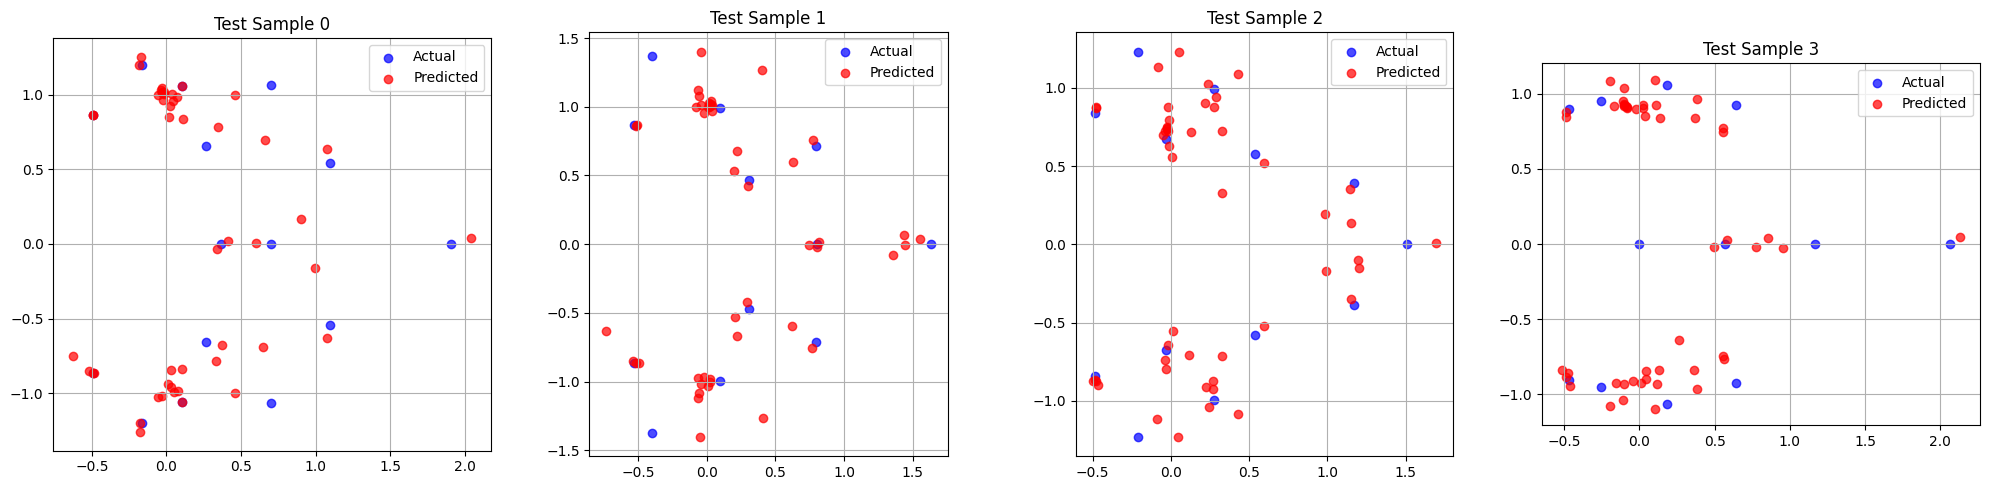

In [25]:
# Get a single batch from the test loader
x_tensor, x_mask, y_tensor = next(iter(test_loader))
x_tensor = x_tensor.to(device)
x_mask   = x_mask.to(device)
y_tensor = y_tensor.to(device)

# Forward pass
with torch.no_grad():
    pred = model(x_tensor, x_mask)  # (B, M, 2)

# Extract actual target roots (removing padding)
y_real = y_tensor[..., :2]
y_mask = (y_tensor[..., 2] == 0)
actual_points = [y_real[i][y_mask[i]] for i in range(x_tensor.size(0))]  # no .cpu() yet
pred_points = [pred[i] for i in range(x_tensor.size(0))]  # no .cpu() yet

# Define Chamfer loss function
def chamfer_loss_single(pred, target):
    pred = pred.unsqueeze(0)   # (1, M, 2)
    target = target.unsqueeze(0)  # (1, N, 2)

    diff1 = torch.cdist(pred, target, p=2)  # (1, M, N)
    diff2 = diff1.transpose(1, 2)           # (1, N, M)

    loss1 = diff1.min(dim=2)[0].mean()
    loss2 = diff2.min(dim=2)[0].mean()
    return loss1 + loss2

# Plot and print loss
num_samples_to_plot = min(4, len(actual_points))
fig, axes = plt.subplots(1, num_samples_to_plot, figsize=(5 * num_samples_to_plot, 5))

if num_samples_to_plot == 1:
    axes = [axes]

for i in range(num_samples_to_plot):
    # Plot points
    ax = axes[i]
    actual_np = actual_points[i].cpu().numpy()
    pred_np = pred_points[i].cpu().numpy()

    ax.set_title(f"Test Sample {i}")
    ax.scatter(*zip(*actual_np), c='blue', label='Actual', alpha=0.7)
    ax.scatter(*zip(*pred_np), c='red', label='Predicted', alpha=0.7)
    ax.legend()
    ax.set_aspect('equal')
    ax.grid(True)

    # Compute and print loss
    loss = chamfer_loss_single(pred_points[i], actual_points[i])
    print(f"Sample {i}: Chamfer Loss = {loss.item():.4f}")

plt.tight_layout()
plt.show()